## Overview
This dataset contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
Aiming to segment the Customers using RFM model so that the company can target its customers efficiently.

<a id="a"></a> <br>
## Step 1 : Reading and Understanding Data

In [21]:
# import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings("ignore")

In [22]:
# Reading the data 
retail = pd.read_csv('data.csv',  encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [23]:
# shape of df
retail.shape

(541909, 8)

In [24]:
# basic info of dataset
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<a id="3"></a> <br>
## Step 2 : Data Cleansing

In [25]:
# Calculating the % of missing values 
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [26]:
# Droping rows having missing values
retail = retail.dropna()
# Check null values again to see if they have already been dropped or not
retail.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [27]:
# Changing the datatype of CustomerID and InvoiceDate
retail['CustomerID'] = retail['CustomerID'].astype(str).str.rstrip('.0')
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [28]:
# Drop rows that have Quantity <= 0 and UnitPrice <= 0
retail = retail[(retail['Quantity'] > 0) & (retail['UnitPrice'] > 0)]

In [29]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  object        
 7   Country      397884 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.3+ MB


<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase of each customer. (Lower score is better)
- F (Frequency): Number of tracsactions of each customer. (Higher score is better)
- M (Monetary): Total revenue contributed of each customer. (Higher score is better)

In [30]:
# New Attribute : Monetary
retail['Monetary'] = retail['Quantity'] * retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Monetary'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Monetary
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,1235,334.40


In [31]:
# New Attribute : Frequency
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346,1
1,12347,182
2,12348,31
3,12349,73
4,1235,17


In [32]:
# New Attribute: Recency

# Merging the two dfs
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Monetary,Frequency
0,12346,77183.60,1
1,12347,4310.00,182
2,12348,1797.24,31
3,12349,1757.55,73
4,1235,334.40,17


In [33]:
# Compute the maximum date to know the last transaction date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [34]:
# Compute the difference between max date and transaction date
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Monetary,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,1785,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,1785,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,1785,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,1785,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,1785,United Kingdom,20.34,373 days 04:24:00


In [35]:
# Compute last transaction date to get the recency of customers
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346,325 days 02:49:00
1,12347,1 days 20:58:00
2,12348,74 days 23:37:00
3,12349,18 days 02:59:00
4,1235,309 days 20:49:00


In [36]:
# Extract number of days only
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346,325
1,12347,1
2,12348,74
3,12349,18
4,1235,309


In [37]:
# Merge 3 dataframes (r,f,m) to get the final RFM dataframe
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Monetary,Frequency,Recency
0,12346,77183.60,1,325
1,12347,4310.00,182,1
2,12348,1797.24,31,74
3,12349,1757.55,73,18
4,1235,334.40,17,309


#### Remove Outliers


Text(0.5, 0, 'Attributes')

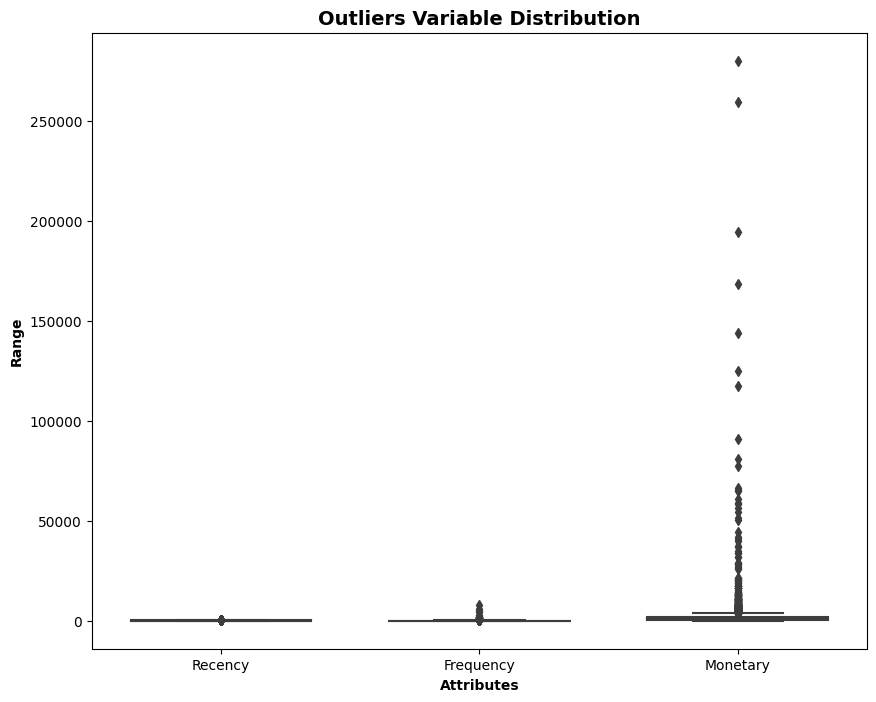

In [38]:
# Outlier Analysis of Monetary, Frequency and Recency
attributes = ['Recency','Frequency','Monetary']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], whis=1.5, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [39]:
# Removing outliers for Monetary
Q1 = rfm.Monetary.quantile(0.25)
Q3 = rfm.Monetary.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Monetary >= Q1 - 1.5*IQR) & (rfm.Monetary <= Q3 + 1.5*IQR)]

# Removing outliers for Recency
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing outliers for Frequency
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Scale the Attributes

There are two common ways of scaling:

1. Min-Max Scaler
2. Standard Scaler 

Here, we will use Standard Scaler.

In [40]:
# Rescaling the attributes
rfm_df = rfm[['Monetary', 'Frequency', 'Recency']]

# Using StandardScaler
scaler = StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3586, 3)

In [41]:
# Make a new dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Monetary,Frequency,Recency
0,1.293234,-0.384518,-0.246172
1,1.240948,0.630165,-0.830527
2,-0.633865,-0.722746,2.206033
3,2.226985,0.920074,-0.653134
4,-0.957147,-1.036814,1.099932


<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

Here, we will use K-means clustering for segmentating the customers

#### Finding the Optimal Number of Clusters

The Elbow Method is one of the most popular methods to determine the optimal value of clusters.

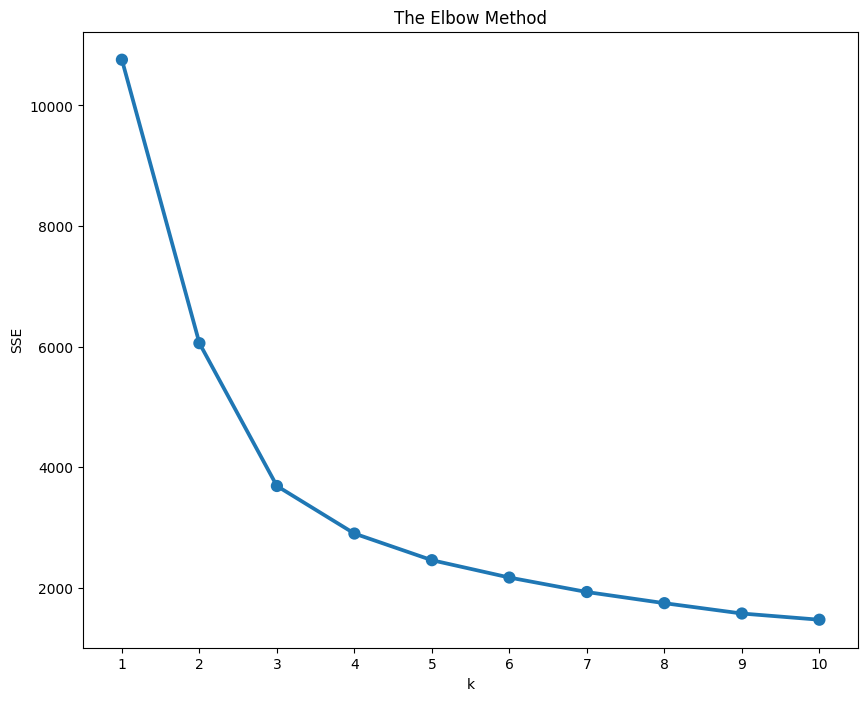

In [42]:
# Elbow curve
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_df_scaled)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

=> Dividing the dataset into 3 clusters appears to be the most suitable choice as, starting from this value, the curve gradually transforms into a linear line.

#### Silhouette Analysis
Second method to divide suitable clusters is to use Silhouette score:
* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [43]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)

    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters = {0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters = 2, the silhouette score is 0.42707755685494364
For n_clusters = 3, the silhouette score is 0.44014668278149344
For n_clusters = 4, the silhouette score is 0.40884330860718976
For n_clusters = 5, the silhouette score is 0.40341887225858863
For n_clusters = 6, the silhouette score is 0.356741677248072
For n_clusters = 7, the silhouette score is 0.33144695907448063
For n_clusters = 8, the silhouette score is 0.34187959093446896


=> n_cluster = 3 has the highest silhouette score.

In [44]:
# Fit K-means model with k = 3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [45]:
 kmeans.labels_

array([1, 0, 2, ..., 2, 1, 0])

In [46]:
# assign the label to new column 'Cluster_Id'
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Monetary,Frequency,Recency,Cluster_Id
2,12348,1797.24,31,74,1
3,12349,1757.55,73,18,0
4,1235,334.40,17,309,2
5,12352,2506.04,85,35,0
6,12353,89.00,4,203,2


<AxesSubplot: xlabel='Cluster_Id', ylabel='Monetary'>

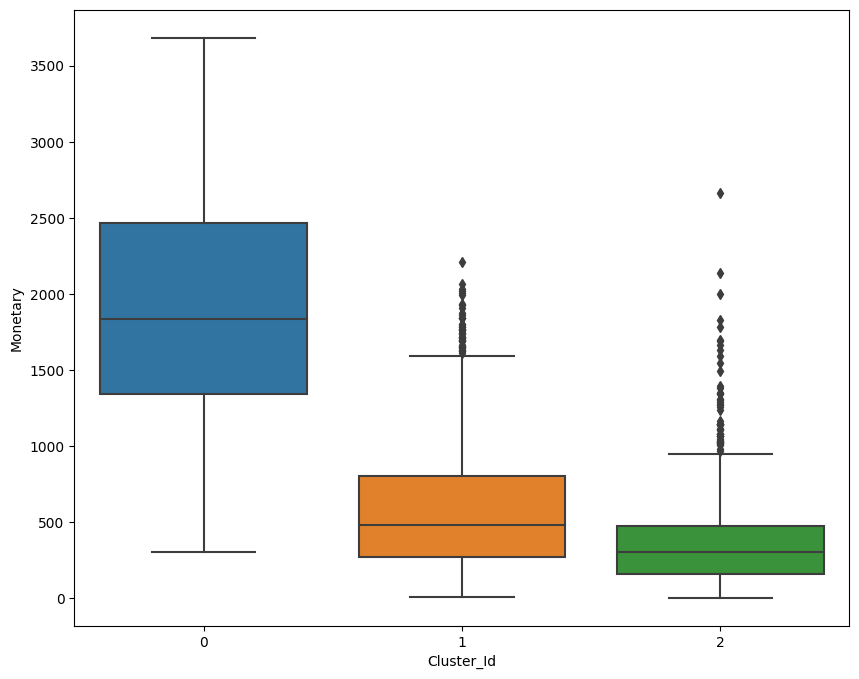

In [47]:
# Box plot to visualize Cluster Id vs Monetary
sns.boxplot(x='Cluster_Id', y='Monetary', data=rfm)

<AxesSubplot: xlabel='Cluster_Id', ylabel='Frequency'>

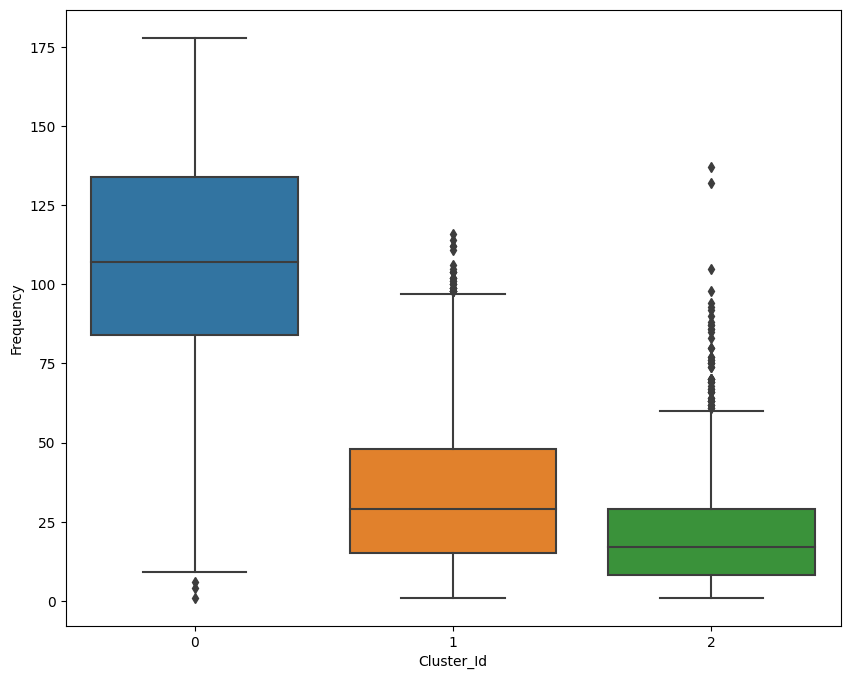

In [48]:
# Box plot to visualize Cluster Id vs Frequency
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

<AxesSubplot: xlabel='Cluster_Id', ylabel='Recency'>

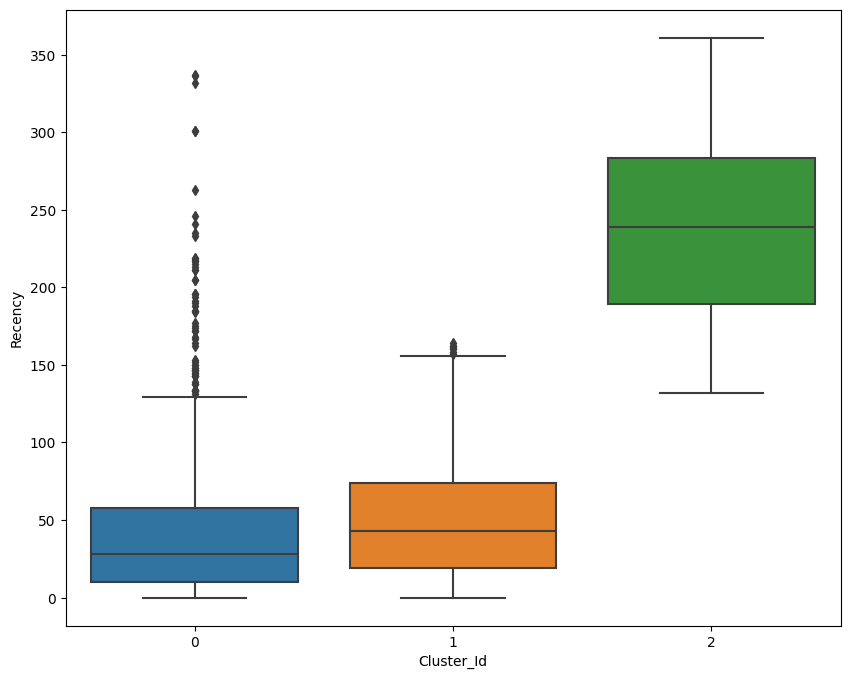

In [49]:
# Box plot to visualize Cluster Id vs Recency
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

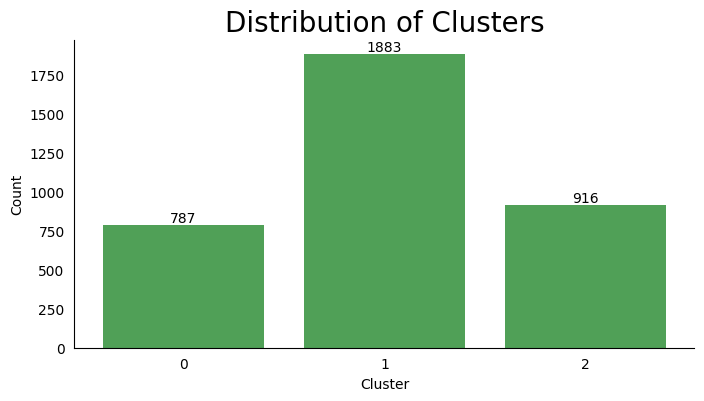

In [50]:
# Draw distribution of each customer segments
result = rfm.Cluster_Id.value_counts()
fig, ax = plt.subplots(figsize=(8, 4))
bar1 = ax.bar(result.index, result.values, color='#50a057')

spines = ['top', 'right']
for s in spines:
    ax.spines[s].set_visible(False)

ax.tick_params(left=False, bottom=False)
ax.grid(False)
ax.bar_label(bar1, size=10)

# Plot the visual
plt.title('Distribution of Clusters', fontsize = 20)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.xticks(result.index)

plt.show()

In [51]:
# Mean values in Recency, Frequency, Monetary for each cluster
cluster = rfm.groupby('Cluster_Id').agg(
    {
        'Recency':'mean',
        'Frequency':'mean',
        'Monetary': 'mean'
    }
).reset_index()
cluster

,Cluster_Id,Recency,Frequency,Monetary
0,0,44.917408,108.167726,1897.622136
1,1,50.332448,33.627191,577.958031
2,2,239.995633,21.608079,374.316681


<a id="5"></a> <br>
## Step 5 : Conclusion:

There are 3 segmentations:
- Customers with Cluster Id 0 are the customers with high Monetary score of transactions and low Frequency score which means they purchase items recently. They are also frequent buyers and considered as `Very Valuable Customers`. This customer group brings the most revenue to the business so that, the business should have some actions to maintain their loyalty and encourage repeat purchases.  

- Cluster Id 1 represents `Valuable Customers` who have a low Recency score and a moderate Monetary score. However, one drawback of this customer group is their infrequent purchases. To enhance their loyalty and drive more frequent buying behavior, the business should prioritize efforts to engage and encourage this customer group to make purchases more frequently.

- Cluster Id 2 represents `Less Valuable Customers`, who are characterized as infrequent buyers with low monetary values. Additionally, they are not recent purchasers. As a result, from a business standpoint, they hold the least significance or importance.